In [1]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import ale_py

import torch
from torch import nn
from torch.distributions import Categorical

import cv2
import matplotlib.pyplot as plt
from collections import deque

import numpy as np

from ppo import PPO, DEVICE

In [2]:
gym.register_envs(ale_py)

env = gym.make("ALE/Breakout-v5", render_mode=None)
env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=True, frame_skip=1, terminal_on_life_loss=True)

In [3]:
def preprocess_obs(obs, crop_top=18):
    obs = cv2.resize(obs, (84, 110))
    return obs[crop_top: crop_top + 84, :]

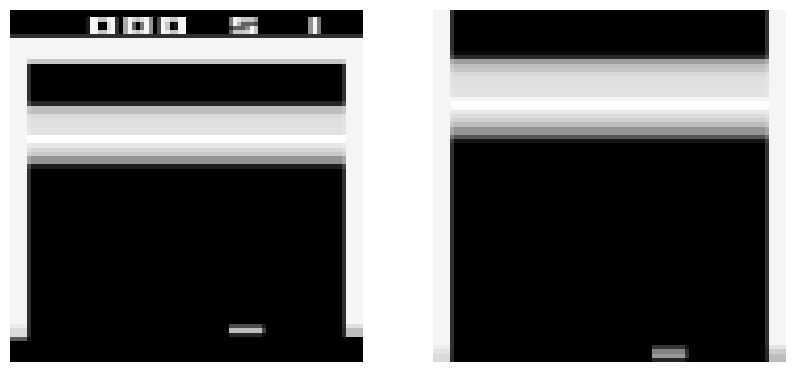

(84, 84) (84, 84)


In [4]:
obs, info = env.reset()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(obs, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocess_obs(obs), cmap='gray')
plt.axis('off')

plt.show()

print(obs.shape, preprocess_obs(obs).shape)

In [5]:
K = 15
total_frames = 1_000_000_000
max_ep_frames = 20_000
policy_update_freq = 100

In [ ]:
ppo = PPO()

<All keys matched successfully>

In [ ]:
frame = 0
num_episodes = 0

max_reward = -float('inf')

ACTION_MAP = [0, 2, 3]  # NOOP, LEFT, RIGHT

while frame < total_frames:
    env.reset()
    env.step(1)  # FIRE
    obs, _, _, _, _ = env.step(1)  # FIRE

    frame_stack = deque([preprocess_obs(obs)] * 4, maxlen=4)

    ep_reward = 0

    for _ in range(max_ep_frames):
        action_idx = ppo.get_action(np.array(frame_stack))

        action = ACTION_MAP[action_idx]
        obs, reward, terminated, truncated, info = env.step(action)

        reward -= 0.01  # time penalty
        done = terminated or truncated
        
        if done:
            reward -= 1.0  # penalty for losing the game

        frame_stack.append(preprocess_obs(obs))

        ppo.add_reward(reward, done)

        ep_reward += reward
        frame += 1
        
        if done:
            break
        
    if num_episodes % policy_update_freq == 0:
        rewards = ppo.buffer['rewards']
        mean_reward = sum(rewards) / len(rewards)
        
        print("Training...")
        print(f"Buffer size: {len(rewards)} frames Mean reward: {mean_reward:.3f}")

        ppo.entropy_coeff = max(0.01, 0.1 - (frame / 1_500_000) * 0.1)      
        ppo.update(K=K)

        torch.save(ppo.policy.state_dict(), f"models/model_{num_episodes}.pth")
        print(f"Saved model at episode {num_episodes} frame {frame}")

    if ep_reward >= max_reward:
        torch.save(ppo.policy.state_dict(), f"models/best_model.pth")
        max_reward = ep_reward
        
    num_episodes += 1

    if num_episodes % 10 == 0:
        print(f"Episode {num_episodes} Frame: {frame} Episode Reward: {ep_reward:.3f} Max Reward: {max_reward:.3f} Entropy Coeff: {ppo.entropy_coeff:.3f}")

Episode 29710 Frame: 3348466 Episode Reward: 1.330 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29720 Frame: 3350100 Episode Reward: 2.850 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29730 Frame: 3352248 Episode Reward: 4.280 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29740 Frame: 3354232 Episode Reward: 0.700 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29750 Frame: 3356479 Episode Reward: 3.010 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29760 Frame: 3358909 Episode Reward: 4.240 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29770 Frame: 3360532 Episode Reward: 0.700 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29780 Frame: 3362516 Episode Reward: 2.800 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29790 Frame: 3364694 Episode Reward: 4.100 Max Reward: 23.600 Entropy Coeff: 0.100
Episode 29800 Frame: 3366490 Episode Reward: 3.770 Max Reward: 23.600 Entropy Coeff: 0.100
Training...
Buffer size: 20145 frames Mean reward: 0.011
Saved model at episode 29800 fram

KeyboardInterrupt: 